# Coursework: Image Warping
### Visual Computing

This notebook contains exercises related to image warping, image stitching, non-linear distortions, image morphing, and real-time panorama stitching. Bonus questions are included with specific marks indicated.

**Grading Scheme (100 points total)**:

- **Affine Transformations**: 10 points
- **Homographies**: 10 points
- **Projective Transformations**: 10 points
- **Non-linear Distortions and Image Stitching**: 15 points
- **Image Warping and Interpolation**: 25 points
- **Panorama Stitching (Real-Time)**: 15 points
- **Image Morphing (Face morphing, scene transitions, etc.)**: 15 points




### 1. Affine Transformations- Recap (10 points)
Affine transformations map points between two planes while preserving lines and parallelism, but not necessarily angles. In this task, you will explore how affine transformations can be used to transform an image geometrically.
**Task:**
- Implement affine transformations to warp an image using a 2x3 transformation matrix.
- Apply the transformation matrix to change the geometry of the image, such as rotating, scaling, translating, or shearing.
- Visualize the original image and the transformed (warped) image to see how the transformation affects the image.

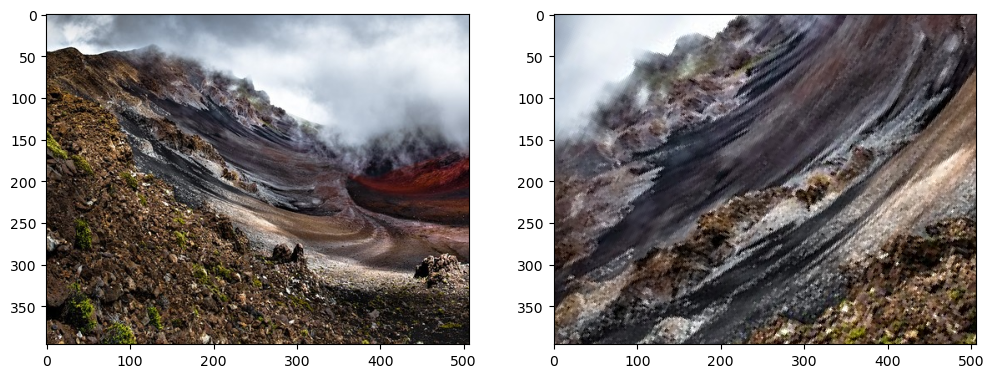

In [38]:
import numpy as np
import dlib
import scipy, scipy.misc, scipy.ndimage
import matplotlib.pyplot as plt
import cv2 as cv

def affine_transformation(image, matrix):
    '''Implement affine transform with backwards mapping'''
    rows, columns = image.shape[:2]

    origin = np.array([(rows + 1)//2, (columns + 1)//2])

    new_image = np.zeros_like(image)
    matrix = np.vstack((matrix, np.array([0,0,1])))

    # Apply inverse matrix to each pixel in blank image
    # Apply nearest neighbour interpolation for pixel values
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            x = j - origin[1]
            y = origin[0] - i
            new_coords = np.linalg.inv(matrix) @ np.array([x,y,1])
            new_coords = np.array([new_coords[0], new_coords[1]])
            new_i = round(origin[0] - new_coords[1])
            new_j = round(origin[1] + new_coords[0])

            if new_i in range(0, rows) and new_j in range(0,columns):
                new_image[i,j] = image[new_i,new_j]

    return new_image
            
image = cv.imread('pano1.jpg')
# Input matrix
matrix = np.array([[1,-2,100], [2,1,50]])

transformed_image = affine_transformation(image, matrix)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(transformed_image, cv.COLOR_BGR2RGB))

### 2. Homographies (5 points + 5 Bonus Points)
Homographies describe a more complex transformation that maps one plane to another, allowing for perspective effects and changes in shape that still preserve straight lines.

**Task:**
- Compute the homography matrix between two sets of corresponding points from two images.
- Apply the homography matrix to warp one image into the coordinate space of the other.
- Use feature detection (like ORB or SIFT) to automatically detect keypoints between the images and align them using the homography.

**Bonus Question (5 points):**
- Investigate how the number of corresponding points affects the accuracy of the homography. Explore what happens if fewer or more points are used and report your observations.

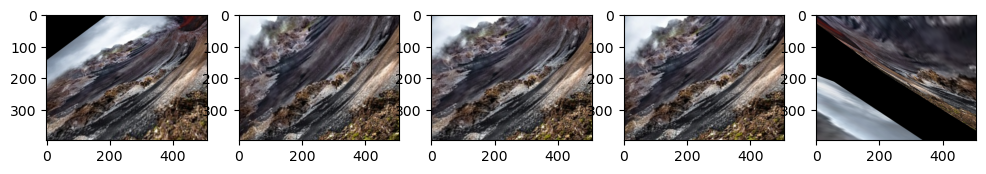

In [ ]:
def orb_homography(image1, image2, num_points=7):
    '''Gets homography matrix between two images using ORB'''
    image1 = image1.astype(np.uint8)
    image2 = image2.astype(np.uint8)

    orb = cv.ORB_create()
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)

    # closest distance matcher for keypoints
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:num_points]

    srcs = np.float32([kp1[m.queryIdx].pt for m in matches])
    dsts = np.float32([kp2[m.trainIdx].pt for m in matches])

    H, _ = cv.findHomography(srcs, dsts, cv.RANSAC)
    
    return H

def sift_homography(image1, image2, num_points=50):
    '''Gets homography matrix between two images using SIFT'''
    image1 = image1.astype(np.uint8)
    image2 = image2.astype(np.uint8)

    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)

    # knn matcher for matching keypoints
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    good_matches = good_matches[:num_points]

    srcs = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    dsts = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    H, _ = cv.findHomography(srcs, dsts, cv.RANSAC)
    
    return H
    
h,w = image.shape[:2]

warped_images = []
points_test = [5,10,20,50,100]
for i in range(len(points_test)):
    ## choose ORB or SIFT to test number of points
    H = sift_homography(image, transformed_image, points_test[i])
    warped_image = cv.warpPerspective(image.astype(np.uint8), H, (w,h))
    warped_images.append(warped_image)

fig, ax = plt.subplots(1,5, figsize=(12,6))
ax[0].imshow(cv.cvtColor(warped_images[0], cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(warped_images[1], cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(warped_images[2], cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(warped_images[3], cv.COLOR_BGR2RGB))
ax[4].imshow(cv.cvtColor(warped_images[4], cv.COLOR_BGR2RGB))


### 3. Projective Transformations (5 points + 5 Bonus Points)
Projective transformations allow us to map points from one plane to another, but with perspective distortion. This is commonly used in applications like perspective correction and image warping.

**Task:**
- Implement a projective transformation matrix and apply it to warp an image.
- Use this transformation to warp an image as if it is viewed from a different perspective.
- Experiment with multiple projective transformations to create different perspectives and analyze how the image is affected.

**Bonus Question (5 points):**
- Handle cases where the backward mapping (from the target image back to the source) falls outside the image bounds. Implement strategies like padding, extrapolation, or ignoring out-of-bounds pixels.

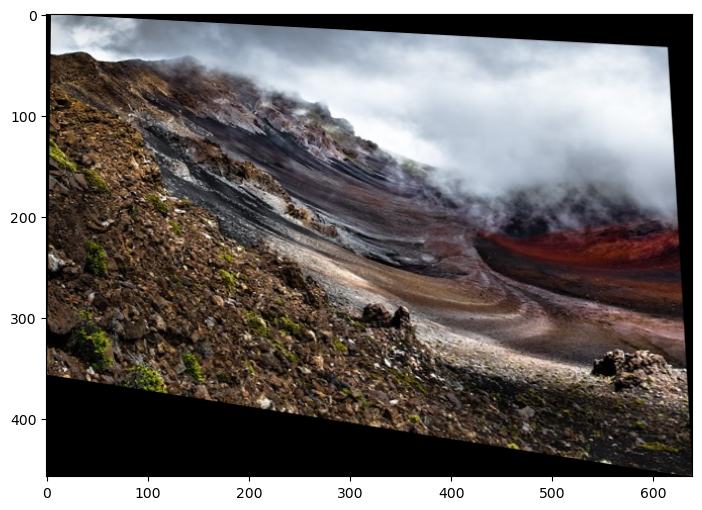

In [45]:
def projective_transform(image, matrix):
    '''Warps image using projective transformation matrix'''
    image = image.astype(np.uint8)
    h,w = image.shape[:2]
    # Get transformed coordinates so that all pixels in image are seen
    corners = cv.perspectiveTransform(np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2), matrix)
    x_min = round(np.min(corners[:,:, 0]) - 0.5)
    x_max = round(np.max(corners[:,:, 0]) + 0.5)
    y_min = round(np.min(corners[:,:, 1]) - 0.5)
    y_max = round(np.max(corners[:,:, 1]) + 0.5)

    bounds = np.array([x_max - x_min, y_max - y_min])

    # Add translation to matrix to fit image back in bounds
    new_matrix = np.array([[1,0,-x_min], [0,1,-y_min], [0,0,1]]) @ matrix
    new_image = cv.warpPerspective(image, new_matrix, (bounds[0], bounds[1]))
    return new_image

projective_matrix = np.float32([[0.99,-0.02,101],[0.04,0.86,50],[-0.0003,-0.0001,1]])
projective_image = projective_transform(image, projective_matrix)

# Warp image back, and full image can be seen due to previous padding
normal_image = projective_transform(projective_image, np.linalg.inv(projective_matrix))

fig, ax = plt.subplots(1, figsize=(12,6))
ax.imshow(cv.cvtColor(projective_image, cv.COLOR_BGR2RGB))

### 4. Non-Linear Distortions and Image Stitching (15 points)
Non-linear distortions allow you to stretch, compress, or warp an image in non-uniform ways. Image stitching involves aligning multiple images and blending them together to create a larger, seamless composite.

**Task:**
- Apply non-linear distortions to an image, such as using a fisheye effect or other non-linear transformation.
- After experimenting with distortions, move to stitching two or more images together by finding corresponding points, aligning the images using a transformation, and blending them.
- For stitching, make sure to use blending techniques (such as linear blending or multi-band blending) to avoid visible seams where the images overlap.

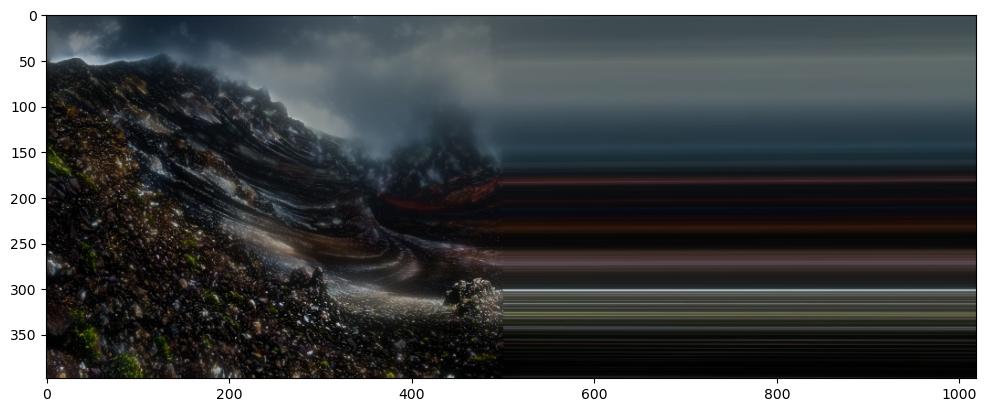

In [79]:
import math

def radial_distortion(image, distort_coffs):
    '''Apply radial distortion to image'''
    image = image.astype(np.uint8)
    h,w = image.shape[:2]
    # Camera matrix changes principal point
    camera_matrix = np.float32([[w,0,w/2], [0,h,h/2], [0,0,1]])
    new_image = cv.undistort(image, camera_matrix, distort_coffs)

    return new_image

def multi_band_blender(image1, image2, mask, levels):
    '''Custom implementation of multi band blending'''
    # Create gaussian pyramids with mask and both images
    gauss_m = [mask]
    gauss1 = [image1]
    gauss2 = [image2]

    for i in range(levels-1):
        gauss1.append(cv.pyrDown(gauss1[i]))
        gauss2.append(cv.pyrDown(gauss2[i]))
        gauss_m.append(cv.pyrDown(gauss_m[i]))

    # Create laplacian pyramids from differences between gaussian layers
    # Image dimensions must match that of the previous layer when scaled up
    laplace1 = []
    laplace2 = []
    for i in range(1, levels):
        laplace1.append(cv.subtract(gauss1[i-1], cv.pyrUp(gauss1[i], dstsize=gauss1[i-1].shape[1::-1])))
        laplace2.append(cv.subtract(gauss2[i-1], cv.pyrUp(gauss2[i], dstsize=gauss2[i-1].shape[1::-1])))

    # Blend both mask and laplacians at each layer of pyramid
    blend_pyr = []
    for l1, l2, m in zip(laplace1, laplace2, gauss_m[:-1]):
        m = np.expand_dims(m, axis=2)
        blended = l2*(m/255) + (1-m/255)*l1
        blend_pyr.append(blended)

    # Reconstruct image from previous blended pyramid
    blended = blend_pyr[-1]
    for blend in blend_pyr[-2::-1]:
        blended = cv.pyrUp(blended, dstsize=blend.shape[1::-1])
        blended += blend
    
    return blended

def image_stitch(images, num_points=100, blending='cv'):
    '''Image stiching for two or more images with multi-band blending'''
    stitched_image = images[0]
    # Go through two images at a time and accumulate resultant image
    for i in range(len(images)-1):
        h1,w1 = stitched_image.shape[:2]
        h2,w2 = images[i+1].shape[:2]

        # SIFT homography better than ORB for image stitching
        H = sift_homography(images[i+1], stitched_image, num_points)

        # Transform corners of second image that stitch with the first
        corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        warped_corners = cv.perspectiveTransform(corners2, H)

        corners = np.concatenate((corners1, warped_corners), axis=0)
        x_min = round(np.min(corners[:,:, 0]) - 0.5)
        x_max = round(np.max(corners[:,:, 0]) + 0.5)
        y_min = round(np.min(corners[:,:, 1]) - 0.5)
        y_max = round(np.max(corners[:,:, 1]) + 0.5)

        # Get bounds of new image space
        bounds = np.array([x_max - x_min, y_max - y_min])

        new_matrix = np.array([[1,0,-x_min], [0,1,-y_min], [0,0,1]]) @ H

        # Use inter linear for interpolation of pixels at seams
        # Border replicate for smoother seams
        warped = cv.warpPerspective(images[i+1], new_matrix, (bounds[0], bounds[1]), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)
        # Create binary mask for second image
        warped_mask = cv.warpPerspective(np.full(warped.shape[:2], 255, dtype=np.uint8), new_matrix, (bounds[0], bounds[1]))

        # Resize first image into new image dimenions
        stitched_r = np.zeros_like(warped, dtype=np.uint8)
        stitched_r[-y_min:-y_min + h1, -x_min:-x_min + w1] = stitched_image

        # Use OpenCV blending as default unless stated otherwise
        if blending == 'custom':
            # Custom built multi band blending by getting max levels from dimensions
            levels = math.log2(max(warped_mask.shape[:2]))
            stitched_image = multi_band_blender(stitched_r, warped, warped_mask, int(levels))
        else:
            # OpenCV blending implementation
            # Create result image and resultant mask that covers whole image
            res = np.zeros_like(warped, dtype=np.uint8)
            res_mask = np.full(warped.shape[:2], 255, dtype=np.uint8)

            blender = cv.detail.Blender.createDefault(cv.detail.BLENDER_MULTI_BAND, True)
            blender.prepare((0,0,warped.shape[1], warped.shape[0]))

            # Feed both first and second image with same shape and then blend
            blender.feed(warped, warped_mask, (0,0))
            blender.feed(stitched_r, ~warped_mask, (0,0))
            out, _ = blender.blend(res, res_mask)

            stitched_image = out

    return stitched_image.astype(np.uint8)

# Distortion coefficients
distort = np.array([0,0,0.2,0,0])
distorted_image = radial_distortion(image, distort)

pano1 = cv.imread('pano1.jpg')
pano2 = cv.imread('pano2.jpg')
pano3 = cv.imread('pano3.jpg')

images = [pano3, pano2, pano1]
stitched_image = image_stitch(images)
new_stitched = image_stitch(images, blending='custom')

fig, ax = plt.subplots(1, figsize=(12,6))
ax.imshow(cv.cvtColor(new_stitched, cv.COLOR_BGR2RGB))
# ax[1,2].imshow(cv.cvtColor(distorted_image, cv.COLOR_BGR2RGB))
# ax[0,0].imshow(cv.cvtColor(pano1, cv.COLOR_BGR2RGB))
# ax[0,1].imshow(cv.cvtColor(pano2, cv.COLOR_BGR2RGB))
# ax[0,2].imshow(cv.cvtColor(pano3, cv.COLOR_BGR2RGB))
# ax[1,0].imshow(cv.cvtColor(stitched_image, cv.COLOR_BGR2RGB))
# ax[1,1].imshow(cv.cvtColor(new_stitched, cv.COLOR_BGR2RGB))

### 5. Image Warping and Interpolation (20 points + 5 Bonus Points)
When warping images, pixel coordinates often map to non-integer values. Interpolation helps you estimate pixel values at these non-integer coordinates to avoid visual artifacts like pixelation or blurring.

**Task:**
- Implement nearest-neighbor interpolation to handle sub-pixel coordinates during image warping.
- Implement bilinear interpolation, a more advanced method, to provide smoother results.
- Compare the results of both interpolation techniques by warping the same image and observing the visual differences.

**Bonus Question (5 points):**
- How does interpolation affect the quality of stitched or warped images? Analyze how different interpolation methods can impact the final output and report your observations.

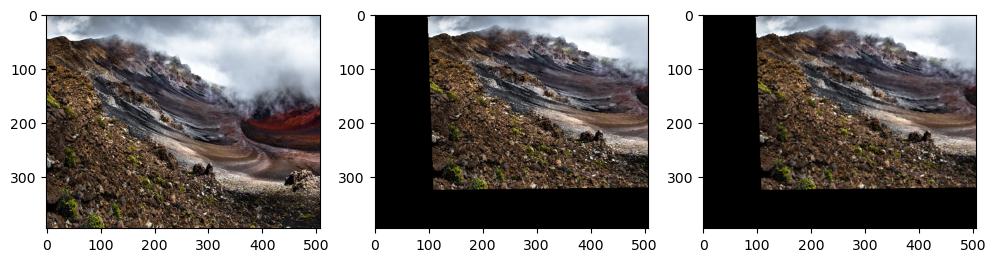

In [81]:
def nn_interpolation(image, matrix):
    '''Nearest-neighbor interpolation of warped image using backwards mapping'''
    rows, columns = image.shape[:2]

    origin = np.array([(columns + 1)/2, (rows + 1)/2])

    new_image = np.zeros_like(image)

    # Apply inverse of matrix to each pixel in new image and get nearest pixel value
    for i in range(rows):
        for j in range(columns):
            x = j - origin[1]
            y = origin[0] - i
            new_coords = np.linalg.inv(matrix) @ np.array([x,y,1])

            # No dividing by 0
            if new_coords[2] == 0:
                continue
            new_coords = np.array([new_coords[0]/new_coords[2], new_coords[1]/new_coords[2]])
            # Get nearest pixel values
            new_i = round(origin[0] - new_coords[1])
            new_j = round(origin[1] + new_coords[0])

            if new_i in range(0, rows) and new_j in range(0,columns):
                new_image[i, j] = image[new_i,new_j]

    return np.uint8(new_image)

def bilinear_interpolation(image, matrix):
    '''Bilinear interpolation of warped image using backwards mapping'''
    rows, columns = image.shape[:2]

    origin = np.array([(columns + 1)/2, (rows + 1)/2])

    new_image = np.zeros_like(image)
    inverse = np.linalg.inv(matrix)

    for i in range(rows):
        for j in range(columns):
            # convert to origin centered coords
            x = j - origin[1]
            y = origin[0] - i
            new_coords = inverse @ np.array([x,y,1])

            if new_coords[2] == 0:
                continue
            new_coords = np.array([new_coords[0]/new_coords[2], new_coords[1]/new_coords[2]])

            # Original x and y
            new_x = new_coords[0]
            new_y = new_coords[1]

            # Convert back to indexed coordinates
            new_i = origin[0] - new_y
            new_j = origin[1] + new_x

            # Check if index is in image bounds
            if round(new_i) in range(0,rows) and round(new_j) in range(0,columns):
                x1, y1 = (int(new_x), int(new_y))
                x2, y2 = (x1-1 if new_x < 0 else x1+1, y1-1 if new_y < 0 else y1+1)
                
                # Get 2x2 neighbourhood of coordinate
                i1, i2 = (round(new_i) - 1, round(new_i)) if round(new_i) != 0 else (0,1)
                j1, j2 = (round(new_j) - 1, round(new_j)) if round(new_j) != 0 else (0,1)

                # Get pixel values of each pixel in neighbourhood
                q11, q12, q21, q22 = (image[i2,j1], image[i1,j1], image[i2,j2], image[i1,j2])

                # Apply bilinear interpolation
                r1 = q11*((x2-new_x)/(x2-x1)) + q21*((new_x-x1)/(x2-x1))
                r2 = q12*((x2-new_x)/(x2-x1)) + q22*((new_x-x1)/(x2-x1))

                p = r1*((y2-new_y)/(y2-y1)) + r2*((new_y-y1)/(y2-y1))
                p = np.round(p)

                new_image[i,j] = p
    
    return np.uint8(new_image)


matrix = np.float32([[1.02,-0.02,101],[0.04,0.86,52],[-0.0004,-0.0001,1]])
nn_warped_image = nn_interpolation(image, matrix)
bilinear_warped_image = bilinear_interpolation(image, matrix)

fig, ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(nn_warped_image, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(bilinear_warped_image, cv.COLOR_BGR2RGB))

### 6. Panorama Stitching (Real-Time) (15 points)
Panorama stitching involves aligning and stitching together multiple images to create a single wide-angle composite. Real-time panorama stitching takes this a step further, allowing for immediate feedback and dynamic composition as more images are added.

**Task:**
- Implement real-time panorama stitching with multiple images.
- Use projective transformations to align images and blend them smoothly.
- Ensure that the stitched images have minimal visible seams and apply real-time adjustments as new images are added.

**HINT:**
 You can explore techniques like feathering, linear blending, or multi-band blending for better panaromas.

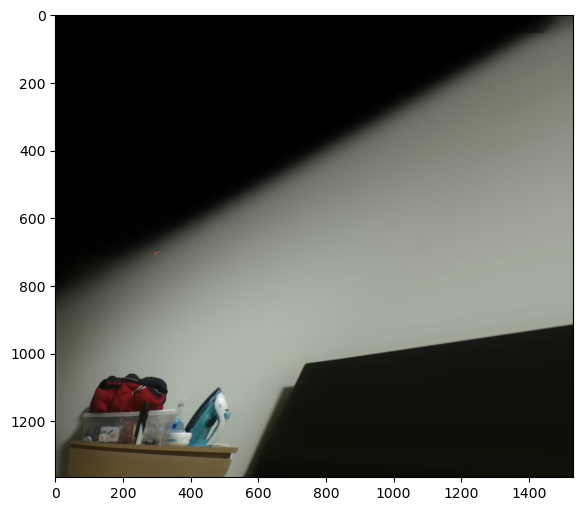

In [10]:
import cv2 as cv
import matplotlib.pyplot as plt

def panorama_stitcher(feed=0):
    '''Real-time panorama stitching'''
    # Get webcam feed
    cap = cv.VideoCapture(feed)

    # Initialse panorama image
    panorama = None

    # Check if camera available
    if not cap.isOpened():
        print("Couldn't open camera")
        exit()

    # Create new window to show stitching in real time
    cv.namedWindow('Panorama', cv.WINDOW_NORMAL)
    # Press esc to quit
    while cv.waitKey(1) != 27:
        ret, frame = cap.read()
        if not ret:
            break
        if panorama is None:
            panorama = frame
        else:
            # Stitch current frame to overall image
            panorama = image_stitch([panorama, frame])
                
        cv.imshow('Panorama', panorama)

    cap.release()
    cv.destroyAllWindows()
    return panorama

real_time_pano = panorama_stitcher(0)

fig, ax = plt.subplots(1, figsize=(12,6))
ax.imshow(cv.cvtColor(real_time_pano, cv.COLOR_BGR2RGB))

### 7. Image Morphing (Face Morphing, Scene Transitions) (15 points)
Image morphing is the process of smoothly transitioning from one image to another by combining both geometric warping and cross-dissolving (blending). Common applications include face morphing and smooth transitions between scenes in videos or graphics.

**Task:**
- Morph between two faces or two scenes by first geometrically warping the images so that key features align.
- Use blending techniques to create a smooth transition from one image to another. Ensure that the transition looks gradual and natural, without sudden jumps or artifacts.
- Consider experimenting with intermediate steps to control the pace of the morphing effect.

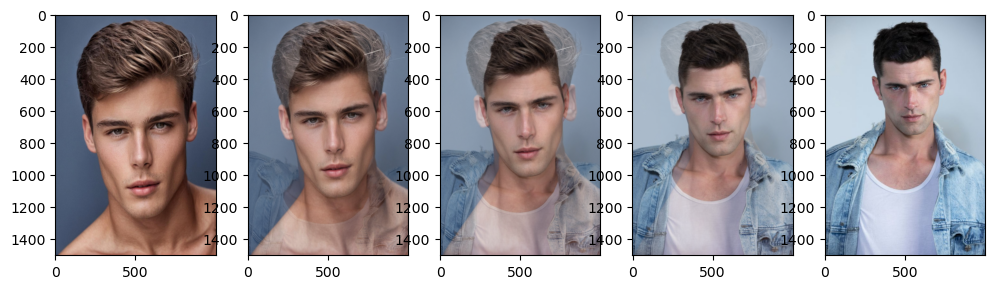

In [11]:
def get_landmarks(img):
    '''Get landmarks for faces'''
    # Create detector from dlib and use previously trained shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    h,w = img.shape[:2]

    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = detector(img_gray)
    for face in faces:
        landmarks = predictor(img_gray, face)
        # Add corners for landmarks as well to get whole image
        extra = [(0,0), (w-1,0), (0,h-1), (w-1,h-1)]
        return [(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)] + extra
    return []

def triangulation(points, size):
    '''Triangulate keypoints'''
    dim = (0,0,size[1],size[0])

    subdiv = cv.Subdiv2D(dim)

    for point in points:
        subdiv.insert((point[0], point[1]))

    triangle_coords = subdiv.getTriangleList()
    triangles = []

    # Add coordinates for each triangle's points
    for t in triangle_coords:
        coords = [(t[0], t[1]), (t[2], t[3]), (t[4], t[5])]
        triangles.append(coords)

    return triangles

def warp_triangle(image1, image2, triangle1, triangle2, triangle, morphed, alpha):
    '''Warp triangles from intermediate triangle points and alpha value'''
    # Get bounding rectangles for each triangle
    bound1 = cv.boundingRect(np.array(triangle1, dtype=np.float32))
    bound2 = cv.boundingRect(np.array(triangle2, dtype=np.float32))
    bound = cv.boundingRect(np.array(triangle, dtype=np.float32))

    # Calculate offset from triangle points and their bounding rectangles to use for warping
    offset1 = [(x - bound1[0], y - bound1[1]) for (x,y) in triangle1]
    offset2 = [(x - bound2[0], y - bound2[1]) for (x,y) in triangle2]
    offset = [(x - bound[0], y - bound[1]) for (x,y) in triangle]

    # Get pixel values inside bounding rectangles
    cropped1 = image1[bound1[1]: bound1[1] + bound1[3], bound1[0]: bound1[0] + bound1[2]]
    cropped2 = image2[bound2[1]: bound2[1] + bound2[3], bound2[0]: bound2[0] + bound2[2]]

    # Get matrices from image offsets to intermediate offsets and warp pixel values
    # Fit within bounds of intermediate rectangles
    matrix1 = cv.getAffineTransform(np.array(offset1, dtype=np.float32), np.array(offset, dtype=np.float32))
    warped1 = cv.warpAffine(np.array(cropped1), matrix1, (bound[2], bound[3]), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT_101)
    matrix2 = cv.getAffineTransform(np.array(offset2, dtype=np.float32), np.array(offset, dtype=np.float32))
    warped2 = cv.warpAffine(np.array(cropped2), matrix2, (bound[2], bound[3]), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT_101)

    # Blend both images using alpha value
    blended = np.float32((1-alpha)*warped1 + alpha*warped2)

    # Create binary mask for triangle shape and fill with blended pixel values
    mask = np.zeros((bound[3], bound[2], 3), dtype=np.float32)
    cv.fillConvexPoly(mask, np.int32(offset), (1,1,1))
    blended *= mask

    # Add 
    morphed[bound[1]:bound[1] + bound[3], bound[0]:bound[0] + bound[2]] *= (1 - mask)
    morphed[bound[1]:bound[1] + bound[3], bound[0]:bound[0] + bound[2]] += blended
    

def image_morph(image1, image2, alpha=0.5):
    '''Take two faces and morph using predefined alpha value'''
    # Get facial landmarks from both images
    points1 = get_landmarks(image1)
    points2 = get_landmarks(image2)
    # Get alpha blended values for each corresponding point
    points = [((1-alpha)*p1[0] + alpha*p2[0], (1-alpha)*p1[1] + alpha*p2[1]) for (p1,p2) in zip(points1, points2)]

    # Triangulate intermediate points
    size = image1.shape
    triangles = triangulation(points, size)

    morphed = np.zeros_like(image1, dtype=np.float32)

    # Match triangles from each image with points in each triangle using closest distances
    for t in triangles:
        idx = [min(range(len(points)), key=lambda i: np.linalg.norm(np.array(points[i]) - np.array(pt))) for pt in t]
        t1 = [points1[i] for i in idx]
        t2 = [points2[i] for i in idx]
        t = [points[i] for i in idx]
        warp_triangle(image1, image2, t1, t2, t, morphed, alpha)

    return np.uint8(morphed)

image1 = cv.imread('model1.jpeg')
image2 = cv.imread('sean.jpg')
size = (1000,1500)

image1 = cv.resize(image1, size)
image2 = cv.resize(image2, size)

fig, ax = plt.subplots(1,5, figsize=(12,6))
ax[0].imshow(cv.cvtColor(image_morph(image1, image2, alpha=0), cv.COLOR_BGR2RGB))
ax[1].imshow(cv.cvtColor(image_morph(image1, image2, alpha=0.25), cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(image_morph(image1, image2, alpha=0.5), cv.COLOR_BGR2RGB))
ax[3].imshow(cv.cvtColor(image_morph(image1, image2, alpha=0.75), cv.COLOR_BGR2RGB))
ax[4].imshow(cv.cvtColor(image_morph(image1, image2, alpha=1), cv.COLOR_BGR2RGB))